### Economic Geography of Interwar Poland
This notebook uses the administrative database and files with economic data to compute the GDP of Interwar Poland on the district level and present an overview of the Polish economic geography in the Interwar Period.

It is a showcase of the use of the whole toolkit. An instance of the AdministrativeHistory class constructed with inputs describing administrative history is used as an API that allows to access, impute, and harmonize data in the database. In the mature form of the toolkit, a PostgreSQL database with economic data will be created and hosted online and a pip-installable package called interwar_poland_database will be publicly shared. The pip package will reconstruct the administrative base locally, and will connect as a read-only-user to the PostgreSQL database to import the necessary data. In this preliminary version of the toolkit, the economic data is stored in the CSV form.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
# Necessary imports
import pandas as pd
import re
from utils.helper_functions import load_config
from core.core import AdministrativeHistory
from utils.helper_functions import extract_date_parts, read_economic_csv_input

In [3]:
plots_output_path = "E:/Studia/Studia magisterskie/Masterarbeit - Wirtschaftwissenschaft/data_plots"

In [4]:
# Load the configuration
config = load_config("config.json")

# Create an administrative history object
administrative_history = AdministrativeHistory(config, load_geometries=True)

Loading changes list...
✅ Loaded 302 validated changes in 0.14 seconds.
Loading initial state...
✅ Loaded initial state.
Loading initial district registry...
✅ Loaded 292 validated districts in 0.07 seconds. Set their initial state timespands to (1921-02-19, 1939-09-01).
Loading initial region registry...
✅ Loaded 19 validated regions in 0.01 seconds. Set their initial state timespands to (1921-02-19, 1939-09-01)
Creating administrative history (sequentially applying changes)...
✅ Successfully applied all changes in 21.65 seconds. Administrative history database created.
Loading territories...
Loaded: powiaty_1921_corrected_names.shp (276 rows)
Loaded: powiaty_1931_corrected_names.shp (283 rows)
Loaded: powiaty_1938_corrected_names_modified.shp (264 rows)
No match found for district 'None' on 1931-04-18
No match found for district 'None' on 1931-04-18
No match found for district 'None' on 1931-04-18
No match found for district 'None' on 1931-04-18
No match found for district 'None' on 

In [5]:
# Use administrative history to harmonize all the input data tables to one administrative state
# administrative_history.harmonize_data()
# administrative_history.post_organization_reorganize_data_tables()

# Initial definitions

### Define constants

In [30]:
# Define paths to csvs with regional data
region_agro_production_costs_path = "input/harmonization_input/data/regions_production_cost_per_ha_ready.csv"
region_total_crops_production_path = "input/harmonization_input/data/regions_total_crops_production_value_ready.csv"
region_total_sown_area_path = "input/harmonization_input/data/regions_total_sown_area_ha_ready.csv"

In [31]:
# Define frequent references used in the whole notebook
reference_date = administrative_history.harmonize_to_date
reference_adm_state = administrative_history.find_adm_state_by_date(reference_date)

# Create empty dfs
empty_dist_df = pd.DataFrame(reference_adm_state.all_district_names(homeland_only=True), columns = ['District'])
empty_dist_df.set_index('District', inplace=True)
empty_region_df = pd.DataFrame(reference_adm_state.all_region_names(homeland_only=True), columns = ['Region'])
empty_region_df.set_index('Region', inplace=True)

In [32]:
# Define a dict mapping voivodships to voivodship group.
r_to_r_group = {
    'BIAŁOSTOCKIE': 'CENTRALNE',
    'KIELECKIE': 'CENTRALNE',
    'KRAKOWSKIE': 'POŁUDNIOWE',
    'LUBELSKIE': 'CENTRALNE',
    'LWOWSKIE': 'POŁUDNIOWE',
    'ŁÓDZKIE': 'CENTRALNE',
    'M. ST. WARSZAWA': 'CENTRALNE',
    'NOWOGRÓDZKIE': 'WSCHODNIE',
    'POLESKIE': 'WSCHODNIE',
    'POMORSKIE': 'ZACHODNIE',
    'POZNAŃSKIE': 'ZACHODNIE',
    'STANISŁAWOWSKIE': 'POŁUDNIOWE',
    'ŚLĄSKIE': 'ZACHODNIE',
    'TARNOPOLSKIE': 'POŁUDNIOWE',
    'WARSZAWSKIE': 'CENTRALNE',
    'WOŁYŃSKIE': 'WSCHODNIE',
    'ZIEMIA WILEŃSKA': 'WSCHODNIE'
    }
# Define colors for r_groups for plotting.
r_group_to_color = {
    'CENTRALNE': '#E69F00',   # Warm orange
    'POŁUDNIOWE': '#56B4E9',  # Sky blue
    'WSCHODNIE': '#009E73',   # Teal green
    'ZACHODNIE': '#CC79A7'    # Reddish purple
}


In [33]:
# Define a dict mapping districts in the go-to administrative state to voivodship group.
r_d_pairs_go_to_adm_state = reference_adm_state.to_address_list(only_homeland=True)
d_to_r_group = {}
for region, dist in r_d_pairs_go_to_adm_state:
    d_to_r_group[dist] = r_to_r_group[region]
# Create a dict mapping region to district
d_to_r = {}
for region, dist in r_d_pairs_go_to_adm_state:
    d_to_r[dist] = region

In [34]:
# Create empty dfs for production outcomes.
production_by_year = {}
for year in range(1924, 1939):
    production_by_year[str(year)] = empty_dist_df.copy()

### Define utils

In [11]:
def distribute_r_values_to_d(region_df, region_value_col, dist_df, dist_value_col, new_col_name, d_to_r):
    """
    This function takes the regional values in the column region_df[region_value_col]
    and distributes every region value according to the proportion of dist_df[dist_value_col]
    for every district to the proportion of the dist_df[dist_value_col] sum for the whole region.

    Parameters:
    - region_df (pd.DataFrame): DataFrame indexed by region names.
    - region_value_col (str): Column name in region_df containing values to be distributed.
    - dist_df (pd.DataFrame): DataFrame indexed by district names.
    - dist_value_col (str): Column name in dist_df used as basis for distribution.
    - new_col_name (str): Name of the new column to store distributed values.
    - d_to_r (dict): Dictionary mapping district names to region names.

    Returns:
    - pd.DataFrame: Copy of dist_df with a new column `new_col_name` with distributed values.
    """

    import pandas as pd

    # Validate index names
    if dist_df.index.name != "District":
        raise ValueError(f"dist_df must have index name 'District', got '{dist_df.index.name}'")
    if region_df.index.name != "Region":
        raise ValueError(f"region_df must have index name 'Region', got '{region_df.index.name}'")

    # Verify all districts are in d_to_r
    missing_districts = set(dist_df.index) - set(d_to_r)
    if missing_districts:
        raise ValueError(f"Missing region mapping for districts: {missing_districts}")

    # Add region information to dist_df
    dist_df = dist_df.copy()
    dist_df["Region"] = dist_df.index.map(d_to_r)

    # Group by region and compute totals for distribution
    dist_grouped = dist_df.groupby("Region")[dist_value_col].transform("sum")

    # Compute share of each district in its region
    dist_df["share"] = dist_df[dist_value_col] / dist_grouped

    # Map regional values from region_df
    dist_df["regional_value"] = dist_df["Region"].map(region_df[region_value_col])

    # Final distributed value
    dist_df[new_col_name] = dist_df["share"] * dist_df["regional_value"]

    # Drop temporary columns
    return dist_df.drop(columns=["Region", "share", "regional_value"])
    

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

def plot_values_over_time(year_df_dict, values_column, adm_level='District',
                          color_by_district=False,
                          d_to_r_group=None,
                          r_group_to_color=None):
    """
    Plots values over time from a dictionary of {year: DataFrame}.

    Parameters:
    - year_df_dict (dict): Dictionary with year as keys and DataFrames as values.
    - values_column (str): Name of the column with values to plot.
    - data_level_column (str): Name of the column representing districts or data level.
    - color_by_district (bool): Whether to color-code points.
    - d_to_r_group (dict): Mapping from district to region group.
    - r_group_to_color (dict): Mapping from region group to color.

    Returns:
    - None (shows the plot)
    """

    # Combine all years into a single DataFrame
    all_years_data = []
    for year, df in year_df_dict.items():
        if df.index.name != adm_level:
            raise ValueError(f"The df for year {year} in year_df_dict index name must be '{adm_level}'. Found: {df.index.name}.")
        temp = df.copy()
        temp['Year'] = year
        if values_column in temp.columns:
            all_years_data.append(temp[['Year', values_column]].reset_index())
            print(f"Added values from {values_column} to plot.")
        else:
            print(f"The df for year {year} doesn't contain {values_column} column.")

    if not all_years_data:
        raise ValueError("No valid data to plot. Check column names.")

    combined_df = pd.concat(all_years_data, ignore_index=True)

    if color_by_district:
        if d_to_r_group is None or r_group_to_color is None:
            raise ValueError("To color by district, both 'd_to_r_group' and 'r_group_to_color' must be provided.")

        # Validate all districts are mapped
        unique_districts = combined_df[adm_level].unique()
        unmapped_districts = [d for d in unique_districts if d not in d_to_r_group]
        if unmapped_districts:
            raise ValueError(f"The following districts are missing in 'd_to_r_group': {unmapped_districts}")

        # Validate all region groups are mapped
        combined_df['Region Group'] = combined_df[adm_level].map(d_to_r_group)
        unique_region_groups = combined_df['Region Group'].unique()
        unmapped_region_groups = [r for r in unique_region_groups if r not in r_group_to_color.keys()]
        if unmapped_region_groups:
            raise ValueError(f"The following region groups are missing in 'r_group_to_color': {unmapped_region_groups}")

        # Assign colors
        combined_df['Color'] = combined_df['Region Group'].map(r_group_to_color)

        # Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(
            combined_df['Year'],
            combined_df[values_column],
            c=combined_df['Color'],
            alpha=0.7
        )

        # Custom legend
        legend_handles = [
            mpatches.Patch(color=color, label=region)
            for region, color in r_group_to_color.items()
        ]
        plt.legend(handles=legend_handles, title="Region Group", bbox_to_anchor=(1.05, 1), loc='upper left')

    else:
        # Default plotting
        plt.figure(figsize=(10, 6))
        plt.scatter(combined_df['Year'], combined_df[values_column], alpha=0.7)

    plt.title(f'{values_column.replace("_", " ")} by {adm_level} Over Time')
    plt.xlabel('Year')
    plt.ylabel(values_column.replace('_', ' '))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Verify data tables are loading properly

In [13]:
example_df, example_data_table_metadata, example_adm_state_date = administrative_history.load_data_table(data_table_id = '1921-total_population_ready_clean', version='harmonized')

In [14]:
example_df

Total Population: Together
District                                             
AUGUSTOWSKI                              62384.000000
BIAŁOSTOCKI                             184146.376503
BIELSKI (BIELSK PODLASKI)               147095.000000
GRODZIEŃSKI                             149375.997513
ŁOMŻYŃSKI                               137981.806538
...                                               ...
DZIŚNIEŃSKI                             128165.635329
WILEJSKI                                 93200.469577
WILEŃSKO-TROCKI                          16653.533046
POSTAWSKI                                78842.951060
MOŁODECZAŃSKI                            70324.667135

[264 rows x 1 columns]

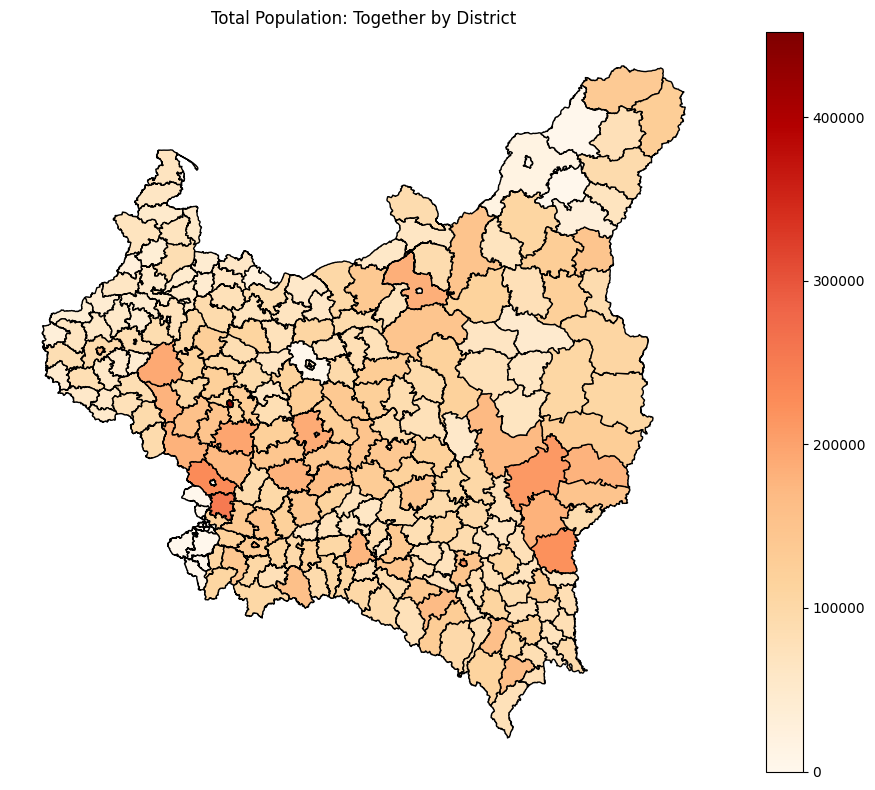

In [15]:
administrative_history.plot_dataset(df = example_df, col_name = 'Total Population: Together', adm_level='District', adm_state_date=example_adm_state_date)

# Agriculture

## Crops

### Prepare prices and yields data for 5 main crops

Load crop prices for 5 main crops:
- 'Pszenica',
- 'Żyto',
- 'Jęczmień',
- 'Owies',
- 'Ziemniaki'.

In cases where prices of multiple crop subtypes are given, I choose:
- 'Ziemniaki: Jadalne', where 'Ziemniaki: Jadalne' and 'Ziemniaki: Fabryczne' are given,
- 'Jęczmień: Browarny', where 'Jęczmień: Browarny', and 'Jęczmień: Innych gatunków' or 'Jęczmień: Na kaszę' are given.

In [17]:
columns_to_select = ['Pszenica: Together', 'Żyto: Together', 'Jęczmień: Together', 'Jęczmień: Ogółem', 'Owies: Together', 'Ziemniaki: Together', 'Ziemniaki: Jadalne', 'Jęczmień: Browarny']
# Load the crops size
crops_prices_data_table_ids = [data_table.data_table_id for data_table in administrative_history.harmonized_data_metadata if data_table.category=='Crops prices']
crops_prices_dfs = [administrative_history.load_data_table(data_table_id = crops_data_table_id, version = 'harmonized') for crops_data_table_id in crops_prices_data_table_ids]
crops_prices_year_df = {extract_date_parts(metadata.date)[0]: df for df, metadata, date in crops_prices_dfs if extract_date_parts(metadata.date)[1] == '08' or extract_date_parts(metadata.date)[0] is None}
crops_prices_year_df_clean = {}
for year, df in crops_prices_year_df.items():
    existing_columns = [col for col in columns_to_select if col in df.columns]
    df = df[existing_columns]
    df.columns = [col.split(':')[0].strip() for col in df.columns]
    crops_prices_year_df_clean[year] = df

Load crops yields data

In [18]:
# Load the crops prices
columns_to_select = ['Pszenica: Together', 'Żyto: Together', 'Jęczmień: Together', 'Owies: Together', 'Ziemniaki: Together']
crops_size_data_table_ids = [data_table.data_table_id for data_table in administrative_history.harmonized_data_metadata if data_table.category=='Crops - Size']
crops_size_dfs = [administrative_history.load_data_table(data_table_id = crops_data_table_id, version = 'harmonized') for crops_data_table_id in crops_size_data_table_ids]
crops_size_year_df = {extract_date_parts(metadata.date)[0]: df for df, metadata, date in crops_size_dfs}
crops_size_year_df_clean = {}
for year, df in crops_size_year_df.items():
    existing_columns = [col for col in columns_to_select if col in df.columns]
    df = df[existing_columns]
    df.columns = [col.split(':')[0].strip() for col in df.columns]
    crops_size_year_df_clean[year] = df

I load 5 main crops index computed on the basis of data for all years by Wronski et al. (2025) on the basis of voivodship average prices for 5 main crops.

In [19]:
price_index_5_main_crops = {
    1924: 1.00,
    1925: 1.34,
    1926: 2.12,
    1927: 2.78,
    1928: 3.25,
    1929: 2.06,
    1930: 1.55,
    1931: 1.44,
    1932: 1.24,
    1933: 1.07,
    1934: 1.07,
    1935: 0.84,
    1936: 0.99,
    1937: 1.54,
    1938: 1.14
}

### Compute Crop Value of 5 main crops

In [20]:
import pandas as pd

crops_production_years = {}

# Find years present in both datasets
common_years = sorted(set(crops_size_year_df_clean.keys()) & set(crops_prices_year_df_clean.keys()))

for year in common_years:
    yield_df = crops_size_year_df_clean[year]
    price_df = crops_prices_year_df_clean[year]

    # Ensure both dfs have the same columns (crops) and index
    if set(yield_df.columns) != set(price_df.columns):
        raise ValueError(f"Crop mismatch in year {year}:\nYield: {yield_df.columns}\nPrice: {price_df.columns}")
    if set(yield_df.index) != set(price_df.index):
        missing_in_price_df_index = set(yield_df.index) - set(price_df.index)
        missing_in_yield_df_index = set(price_df.index) - set(yield_df.index)
        raise ValueError(f"Index mismatch in year {year}:\nMissing in price df: {missing_in_price_df_index}.\nMissing in yield df: {missing_in_yield_df_index}.")

    # Compute total crop value for each crop
    result_df = yield_df*price_df
    # Compute the total value of the 5 main crops by summing across all crop columns
    result_df['5 Main Crops Value'] = result_df.sum(axis=1)

    result_df['5 Main Crops Value %'] = 100*(result_df[['5 Main Crops Value']]/result_df[['5 Main Crops Value']].max())

    crops_production_years[year] = result_df


Generate and save plots with 5 Main Crops total production value.

In [ ]:
for year, df in crops_production_years.items():
    plot_path = plots_output_path + f"/5_Crops_Value_{year}.png"
    administrative_history.plot_dataset(df = df, col_name = '5 Main Crops Value %', adm_level='District', adm_state_date=reference_date, save_to_path=plot_path, title = f'5 Main Crops Value (% of max. district value) ({year})', cmap = 'Greens')

### Disaggregate regional crop value added from Wroński et al. (2025)

Load regional data from Wronski et al. (2025)

In [21]:
region_total_crops_production = read_economic_csv_input(adm_level='Region', input_csv_path=region_total_crops_production_path)
region_agro_production_costs_per_ha = read_economic_csv_input(adm_level='Region', input_csv_path=region_agro_production_costs_path)
region_total_sown_area = read_economic_csv_input(adm_level='Region', input_csv_path=region_total_sown_area_path)

Attempting to read: input/harmonization_input/data/regions_total_crops_production_value_ready.csv
Successfully read CSV using encoding: utf-8
Attempting to read: input/harmonization_input/data/regions_production_cost_per_ha_ready.csv
Successfully read CSV using encoding: utf-8
Attempting to read: input/harmonization_input/data/regions_total_sown_area_ha_ready.csv
Successfully read CSV using encoding: utf-8


In [22]:
region_agro_production_costs = region_total_sown_area*region_agro_production_costs_per_ha
region_crops_value_added = region_total_crops_production-region_agro_production_costs

In [23]:
crops_production_years['1928']

Pszenica          Żyto      Jęczmień  \
District                                                              
AUGUSTOWSKI                1.076137e+06  7.530410e+06  1.612908e+06   
BIAŁOSTOCKI                1.460629e+06  1.210755e+07  1.752672e+06   
BIELSKI (BIELSK PODLASKI)  3.018810e+06  2.002535e+07  2.036403e+06   
GRODZIEŃSKI                1.748709e+06  2.030771e+07  4.399376e+06   
ŁOMŻYŃSKI                  5.934267e+06  3.300826e+07  3.201937e+06   
...                                 ...           ...           ...   
DZIŚNIEŃSKI                1.877582e+06  1.039965e+07  1.456289e+06   
WILEJSKI                   3.054870e+05  8.938696e+06  3.395872e+06   
WILEŃSKO-TROCKI            8.642883e+05  1.900092e+07  5.210557e+06   
POSTAWSKI                  7.958183e+05  1.012246e+07  1.656450e+06   
MOŁODECZAŃSKI              1.520146e+06  1.296256e+07  3.969479e+06   

                                  Owies     Ziemniaki  5 Main Crops Value  \
District                                                                    
AUGUSTOWSKI                5.984484e+06  8.046881e+06        2.425082e+07   
BIAŁOSTOCKI                3.993206e+06  1.784925e+07        3.716331e+07   
BIELSKI (BIELSK PODLASKI)  5.926129e+06  1.442642e+07        4.543311e+07   
GRODZIEŃSKI                5.982590e+06  2.209112e+07        5.452950e+07   
ŁOMŻYŃSKI                  1.166250e+07  3.291814e+07        8.672511e+07   
...                                 ...           ...                 ...   
DZIŚNIEŃSKI                4.240112e+06  5.831108e+06        2.380474e+07   
WILEJSKI                   3.261241e+06  1.409515e+07        2.999645e+07   
WILEŃSKO-TROCKI            7.081552e+06  2.988091e+07        6.203823e+07   
POSTAWSKI                  1.741480e+06  8.987422e+06        2.330363e+07   
MOŁODECZAŃSKI              9.510671e+06  1.531549e+07        4.327834e+07   

                           5 Main Crops Value %  
District                                         
AUGUSTOWSKI                           14.335122  
BIAŁOSTOCKI                           21.967941  
BIELSKI (BIELSK PODLASKI)             26.856379  
GRODZIEŃSKI                           32.233429  
ŁOMŻYŃSKI                             51.264866  
...                                         ...  
DZIŚNIEŃSKI                           14.071436  
WILEJSKI                              17.731472  
WILEŃSKO-TROCKI                       36.671978  
POSTAWSKI                             13.775221  
MOŁODECZAŃSKI                         25.582654  

[264 rows x 7 columns]

In [25]:
for year, dist_df in crops_production_years.items():
    dist_va_df = distribute_r_values_to_d(region_df=region_crops_value_added, region_value_col=str(year), dist_df=dist_df, dist_value_col = '5 Main Crops Value', new_col_name='Crops Value Added', d_to_r=d_to_r)
    production_by_year[year]['Crops Value Added'] = dist_va_df['Crops Value Added']

## Livestock

### Load Livestock data

In [26]:
# Load industry_permissions datasets
livestock_data_table_ids = [data_table.data_table_id for data_table in administrative_history.harmonized_data_metadata if data_table.category=='Livestock']
livestock_dfs = [administrative_history.load_data_table(data_table_id = livestock_data_table_id, version = 'harmonized') for livestock_data_table_id in livestock_data_table_ids]
livestock_year_df_dict = {extract_date_parts(metadata.date)[0]: df for df, metadata, date in livestock_dfs}
# Add Livestock_Units column
for year, df in livestock_year_df_dict.items():
    horse_units = df['Konie: Together']
    cow_units = df['Bydło rogate: Together']
    pig_units = df['Trzoda chlewna: Together'] / 4

    if 'Owce i kozy: Together' in df.columns:
        sheep_goat_units = df['Owce i kozy: Together'] / 10
        livestock_units = horse_units + cow_units + pig_units + sheep_goat_units
    else:
        goat_units = df.get('Kozy: Together', 0) / 10
        sheep_units = df.get('Owce: Together', 0) / 10
        livestock_units = horse_units + cow_units + pig_units + goat_units + sheep_units

    df['Livestock_Units'] = livestock_units

Generate and save plots with total livestock units.

In [ ]:
for year, df in livestock_year_df_dict.items():
    print(df.columns)
    plot_path = plots_output_path + f"/Livestock_Units_{year}.png"
    administrative_history.plot_dataset(df = df, col_name = 'Livestock_Units', adm_level='District', adm_state_date=reference_date, save_to_path=plot_path, title = f'Livestock Units ({year})', legend_min = 0, legend_max = 250000, cmap = 'OrRd')

### Compute Livestock Value Added

I use the same method as Wronsky et al. (2025) to disaggregate the total animal production, but on on the region, but on the district level.
I rely on the estimates of a renown Polish agricultural economist Ponikowski who estimated that the animal production in 1928 amounted to 59,07% of the crops production.
I further rely on the estimation of another agricultural economist Dederko who assumed the production value of animals be roughly proportional to the formula:
1 horse = 1 cow = 4 pigs = 10 sheep = 10 goats. I compute the number of 'livestock units' for every district this way.

For year n, I use the total crops production in 1928 deflated by average yearly average crop prices index computed by Wronski et al. (2025). I disaggregate this value by the proportion of the livestock units in district d in year n to the total number of livestock units in year 1928.

In [27]:
# Crop price index in relation to 1928 computed by Wronski et al. (2025).
crop_price_index = {'1924': 0.3059, '1925': 0.4096, '1926': 0.6479, '1927': 0.8540, '1928': 1.0000, '1929': 0.6398, '1930': 0.4818, '1931': 0.4640, '1932': 0.3971, '1933': 0.3377, '1934': 0.3425, '1935': 0.2745, '1936': 0.3244, '1937': 0.5056, '1938': 0.3779}
total_crops_production_1928 = 11205070843
    
# Interpolate 1928 livestock units
livestock_year_df_dict['1928'] = (livestock_year_df_dict['1927']+livestock_year_df_dict['1929'])/2
livestock_year_df_dict['1926'] = livestock_year_df_dict['1927'] - (livestock_year_df_dict['1928']-livestock_year_df_dict['1927']) # Extrapolate linearly by one year
total_livestock_units_1928 = sum(livestock_year_df_dict['1928']['Livestock_Units'])
for year, df in livestock_year_df_dict.items():
    production_by_year[year]['Livestock Value Added'] = (df['Livestock_Units']/total_livestock_units_1928)*total_crops_production_1928*crop_price_index[year]


In [34]:
for year, df in production_by_year.items():
    print(df.index[0])

AUGUSTOWSKI
AUGUSTOWSKI
AUGUSTOWSKI
AUGUSTOWSKI
AUGUSTOWSKI
AUGUSTOWSKI
AUGUSTOWSKI
AUGUSTOWSKI
AUGUSTOWSKI
AUGUSTOWSKI
AUGUSTOWSKI
AUGUSTOWSKI
AUGUSTOWSKI
AUGUSTOWSKI
AUGUSTOWSKI


The df for year 1924 doesn't contain Livestock Value Added column.
The df for year 1925 doesn't contain Livestock Value Added column.
Added values from Livestock Value Added to plot.
Added values from Livestock Value Added to plot.
Added values from Livestock Value Added to plot.
Added values from Livestock Value Added to plot.
Added values from Livestock Value Added to plot.
Added values from Livestock Value Added to plot.
Added values from Livestock Value Added to plot.
Added values from Livestock Value Added to plot.
Added values from Livestock Value Added to plot.
Added values from Livestock Value Added to plot.
Added values from Livestock Value Added to plot.
The df for year 1937 doesn't contain Livestock Value Added column.
Added values from Livestock Value Added to plot.


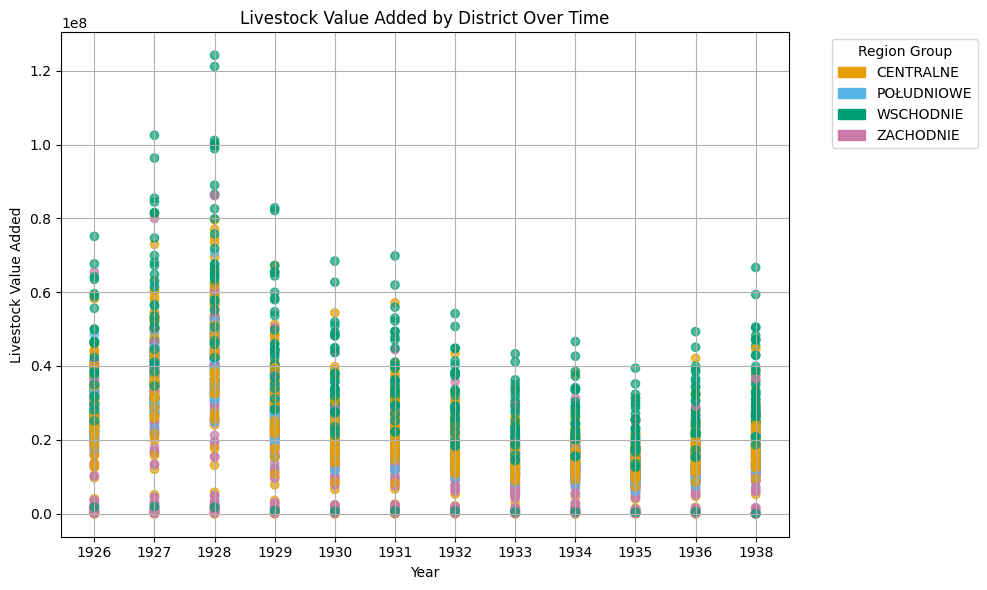

In [40]:
plot_values_over_time(
    year_df_dict=production_by_year,
    values_column='Livestock Value Added',
    color_by_district=True,
    d_to_r_group=d_to_r_group,
    r_group_to_color=r_group_to_color
    )

## Forests

### Load forests data

In [66]:
forests_data_table, forests_metadata, forests_date = administrative_history.load_data_table(data_table_id = '1930-forests_area_ha_ready', version = 'harmonized')
forests_data_table.rename(columns={'Area: Together': 'Total Forest Area'}, inplace = True)
dist_area_data_table, dist_area_metadata, dist_area_date = administrative_history.load_data_table(data_table_id = 'dist_area_baseline_adm_state', version = 'harmonized')
dist_area_data_table.rename(columns={'Area: Together': 'Total District Area'}, inplace = True)
forests_data_table = forests_data_table.merge(dist_area_data_table, on='District', how='left')
forests_data_table['Forest as District Area Proportion'] = forests_data_table['Total Forest Area']/forests_data_table['Total District Area']

Generate and save plots with forest area and forest area in comparison to .

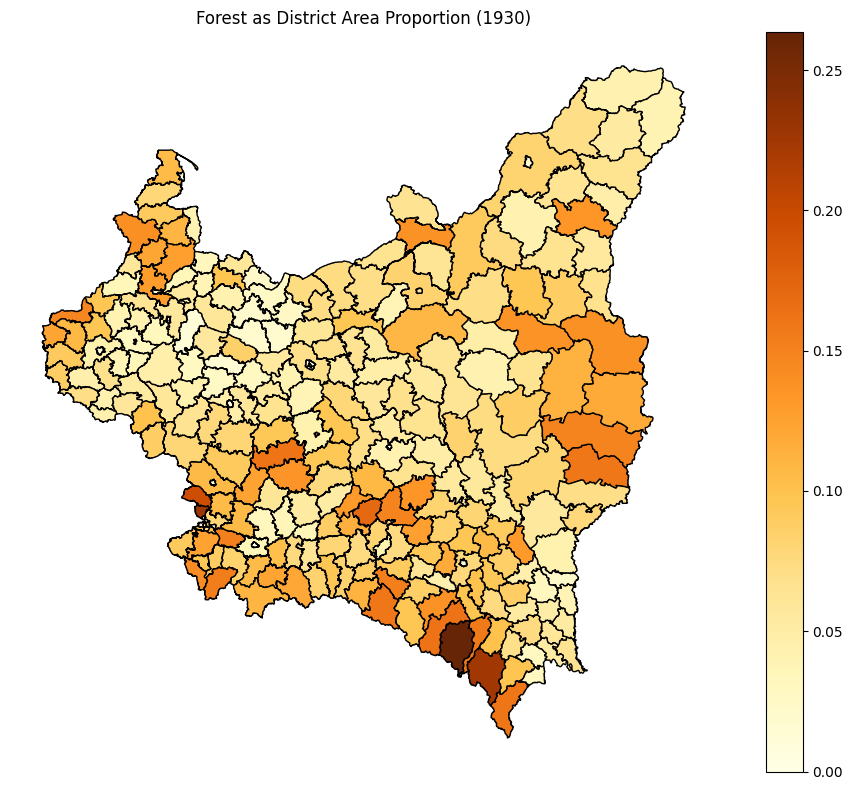

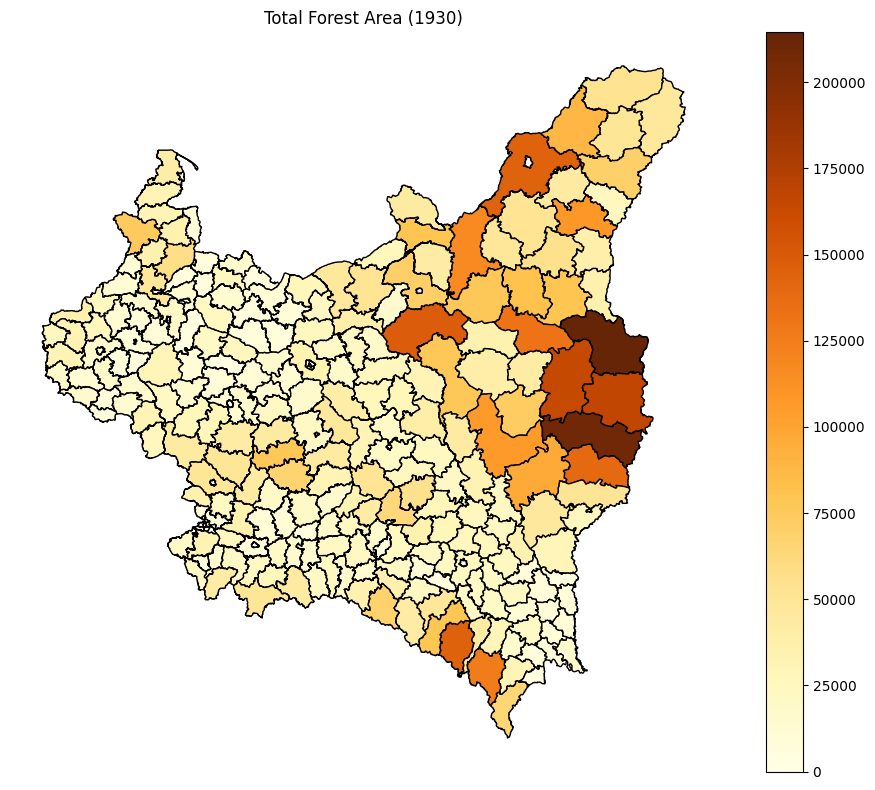

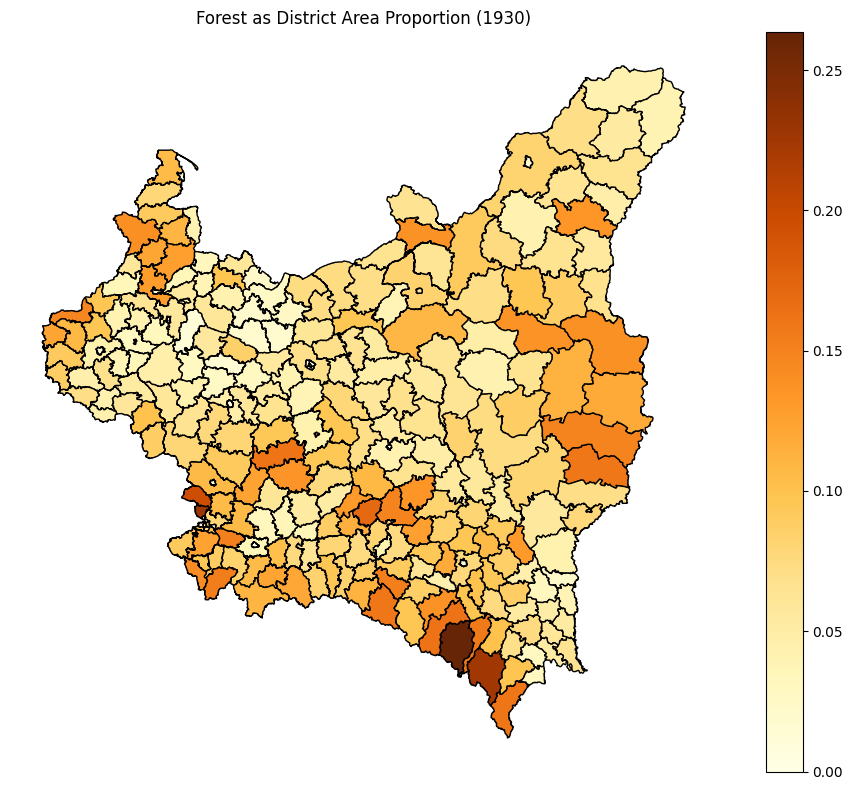

In [67]:
# Plot total forest area:
plot_path = plots_output_path + f"/Total_Forest_Area_{year}.png"
administrative_history.plot_dataset(df = forests_data_table, col_name = 'Total Forest Area', adm_level='District', adm_state_date=example_adm_state_date, save_to_path=plot_path, title = 'Total Forest Area (1930)', cmap = "YlOrBr")

# Plot proportion of forest area to district area:
plot_path = plots_output_path + f"/Proportion_of_Forest_Area_{year}.png"
administrative_history.plot_dataset(df = forests_data_table, col_name = 'Forest as District Area Proportion', adm_level='District', adm_state_date=example_adm_state_date, save_to_path=plot_path, title = 'Forest as District Area Proportion (1930)', cmap = "YlOrBr")

I compute the total value of the forest production as Wronski et al. (2025) - I take yearly incomes of 'Lasy Państwowe' ('State Forests') that controlled and managed 46% of the forests in Poland (Wronski et al., 2025), multiply it by (2.17 = 1/0.46), and spread the incomes according to the forest area per district in 1930. The incomes exist for years 1921-1925 and 1932-1937, for years 1926-1931 they are interpolated with the use of the time series of State Forests' payments to the state budget.

In [68]:
state_forests_incomes = {
    1921: 13_116_000.0,
    1922: 35_291_000.0,
    1923: 33_889_000.0,
    1924: 25_331_000.0,
    1925: 62_522_000.0,
    1926: None,
    1927: None,
    1928: None,
    1929: None,
    1930: None,
    1931: None,
    1932: 120_200_000.0,
    1933: 128_400_000.0,
    1934: 181_300_000.0,
    1935: 210_000_000.0,
    1936: 287_600_000.0,
    1937: 374_100_000.0
    }

prop_total_to_state_forest_area = 2.17

budget_payment = {
    1925: 36_157_000.0,
    1926: 89_287_000.0,
    1927: 118_999_000.0,
    1928: 80_643_000.0,
    1929: 80_395_000.0,
    1930: 72_000_000.0,
    1931: 33_000_000.0,
    1932: 48_000_000.0
}

In [69]:
total_forests_incomes = {year: prop_total_to_state_forest_area*incomes if incomes is not None else None for year, incomes in state_forests_incomes.items()}
print(total_forests_incomes)

{1921: 28461720.0, 1922: 76581470.0, 1923: 73539130.0, 1924: 54968270.0, 1925: 135672740.0, 1926: None, 1927: None, 1928: None, 1929: None, 1930: None, 1931: None, 1932: 260834000.0, 1933: 278628000.0, 1934: 393421000.0, 1935: 455700000.0, 1936: 624092000.0, 1937: 811797000.0}


In [70]:
prop_budget_payment = {}
for year, payment in budget_payment.items():
    prop_budget_payment[year] = payment/budget_payment[1925]
print(prop_budget_payment)

{1925: 1.0, 1926: 2.4694250076057194, 1927: 3.2911745996625825, 1928: 2.230356500815886, 1929: 2.2234975246840167, 1930: 1.9913156511878751, 1931: 0.912686340127776, 1932: 1.3275437674585835}


In [71]:
for year in range(1926, 1932):
    total_forests_incomes[year] = total_forests_incomes[1925]*prop_budget_payment[year]
print(total_forests_incomes)

{1921: 28461720.0, 1922: 76581470.0, 1923: 73539130.0, 1924: 54968270.0, 1925: 135672740.0, 1926: 335033657.0063888, 1927: 446522675.7546256, 1928: 302598577.6425035, 1929: 301668001.5570982, 1930: 270167250.60154325, 1931: 123826656.52570733, 1932: 260834000.0, 1933: 278628000.0, 1934: 393421000.0, 1935: 455700000.0, 1936: 624092000.0, 1937: 811797000.0}


Distribute yearly forest production according to 1930 forest area per district.

In [72]:
for year in range(1924,1938):
    df = forests_data_table[['Total Forest Area']].copy()
    total_area = df['Total Forest Area'].sum()

    # Compute proportional share and assign
    production_by_year[str(year)]['Forest Value Added'] = (df['Total Forest Area']/total_area)*total_forests_incomes[year]

## Sea Fishing

### Sea Fishing Value Added

The values for sea fishing were provided by GUS from 1931 on. All the values are allocated to the district 'MORSKI'. The values for years 1924-1930 is the value from 1931 extrapolated by Wronski et al. (2025) based on the Pomorskie voivodship value of 5 main crops production in the given year in relation to its value of 5 main crops production in year 1931. Voivosdhip Pomorskie was the only on that had access to the sea.

Inland fishing was added by Ponikowski within his estimations of the Livestock production and it's why I don't add it here.

In [54]:
# Values published by GUS (1931-1938) and extrapolated by Wronski et al. (2025) (1924-1930).
sea_fishing_value = {
    1924: 2_747_607.0,
    1925: 4_081_133.0,
    1926: 5_014_687.0,
    1927: 8_833_781.0,
    1928: 10_921_172.0,
    1929: 7_844_862.0,
    1930: 6_542_626.0,
    1931: 2_393_700.0,
    1932: 2_559_700.0,
    1933: 4_589_400.0,
    1934: 3_991_980.0,
    1935: 3_431_700.0,
    1936: 3_986_000.0,
    1937: 5_127_300.0,
    1938: 7_181_700.0
    }

In [55]:
sea_fishing_df = empty_dist_df.copy()
sea_fishing_df['Sea Fishing'] = 0
for year in range(1924, 1938):
    sea_fishing_year = sea_fishing_df.copy()
    sea_fishing_year.loc['MORSKI', 'Sea Fishing'] = sea_fishing_value[year]
    production_by_year[str(year)]['Sea Fishing Value Added'] = sea_fishing_year['Sea Fishing']

## Horticulture

### Horticulture Value Added

I follow Wronski et al. (2025) and take 6.87% (Ponikowski's estimate for total horticulture production in 1928 in proportion to his estimate of the total crops production in 1928), and assume that horticulture amounts to additional 6.87% of crops production to every district's crops in a given year.

In [56]:
horticulture_df = empty_dist_df.copy()
horticulture_year_df_dict = {}
for year in crops_production_years.keys():
    production_by_year[year]['Horticulture Value Added'] = production_by_year[year]['Crops Value Added']*6.87

## Final agriculture production estimation

In [73]:
for year in crops_production_years.keys():
    print(list(production_by_year[year].columns))

['Crops Value Added', 'Livestock Value Added', 'Horticulture Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Agriculture Value Added']
['Crops Value Added', 'Livestock Value Added', 'Horticulture Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Agriculture Value Added']
['Crops Value Added', 'Livestock Value Added', 'Horticulture Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Agriculture Value Added']
['Crops Value Added', 'Livestock Value Added', 'Horticulture Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Agriculture Value Added']
['Crops Value Added', 'Livestock Value Added', 'Horticulture Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Agriculture Value Added']
['Crops Value Added', 'Livestock Value Added', 'Horticulture Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Agriculture Value Added']
['Crops Value Added', 'Livestock Value Added', 'Horticulture Value Added', 'Forest Value Added

In [74]:
# Compute final aggricultural production
for year in crops_production_years.keys():
    production_by_year[year]['Agriculture Value Added'] = production_by_year[year]['Crops Value Added'] + production_by_year[year]['Livestock Value Added'] + production_by_year[year]['Forest Value Added'] + production_by_year[year]['Sea Fishing Value Added'] + production_by_year[year]['Horticulture Value Added']

In [75]:
production_by_year['1930']

Crops Value Added  Livestock Value Added  \
District                                                              
AUGUSTOWSKI                     1.292937e+07           2.446925e+07   
BIAŁOSTOCKI                     1.992996e+07           3.729420e+07   
BIELSKI (BIELSK PODLASKI)       2.894273e+07           5.441347e+07   
GRODZIEŃSKI                     2.982514e+07           3.980160e+07   
ŁOMŻYŃSKI                       5.216759e+07           3.900325e+07   
...                                      ...                    ...   
DZIŚNIEŃSKI                     2.648100e+07           3.790801e+07   
WILEJSKI                        2.566541e+07           3.197312e+07   
WILEŃSKO-TROCKI                 4.578637e+07           5.101036e+07   
POSTAWSKI                       1.715717e+07           2.724571e+07   
MOŁODECZAŃSKI                   1.675885e+07           2.130741e+07   

                           Horticulture Value Added  Forest Value Added  \
District                                                                  
AUGUSTOWSKI                            8.882477e+07        2.589923e+06   
BIAŁOSTOCKI                            1.369188e+08        2.287460e+06   
BIELSKI (BIELSK PODLASKI)              1.988366e+08        4.774203e+06   
GRODZIEŃSKI                            2.048987e+08        3.790380e+06   
ŁOMŻYŃSKI                              3.583913e+08        1.699737e+06   
...                                             ...                 ...   
DZIŚNIEŃSKI                            1.819244e+08        1.532548e+06   
WILEJSKI                               1.763214e+08        2.255620e+06   
WILEŃSKO-TROCKI                        3.145523e+08        4.662246e+06   
POSTAWSKI                              1.178697e+08        1.612972e+06   
MOŁODECZAŃSKI                          1.151333e+08        8.407989e+05   

                           Sea Fishing Value Added  Agriculture Value Added  
District                                                                     
AUGUSTOWSKI                                      0             1.288133e+08  
BIAŁOSTOCKI                                      0             1.964305e+08  
BIELSKI (BIELSK PODLASKI)                        0             2.869670e+08  
GRODZIEŃSKI                                      0             2.783158e+08  
ŁOMŻYŃSKI                                        0             4.512619e+08  
...                                            ...                      ...  
DZIŚNIEŃSKI                                      0             2.478460e+08  
WILEJSKI                                         0             2.362156e+08  
WILEŃSKO-TROCKI                                  0             4.160113e+08  
POSTAWSKI                                        0             1.638856e+08  
MOŁODECZAŃSKI                                    0             1.540404e+08  

[264 rows x 6 columns]

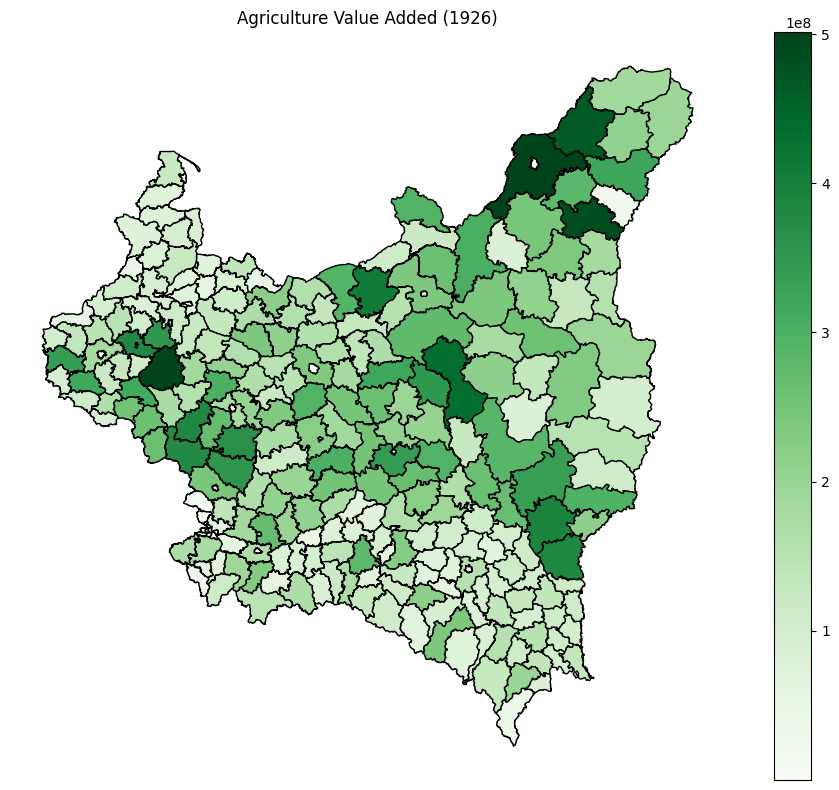

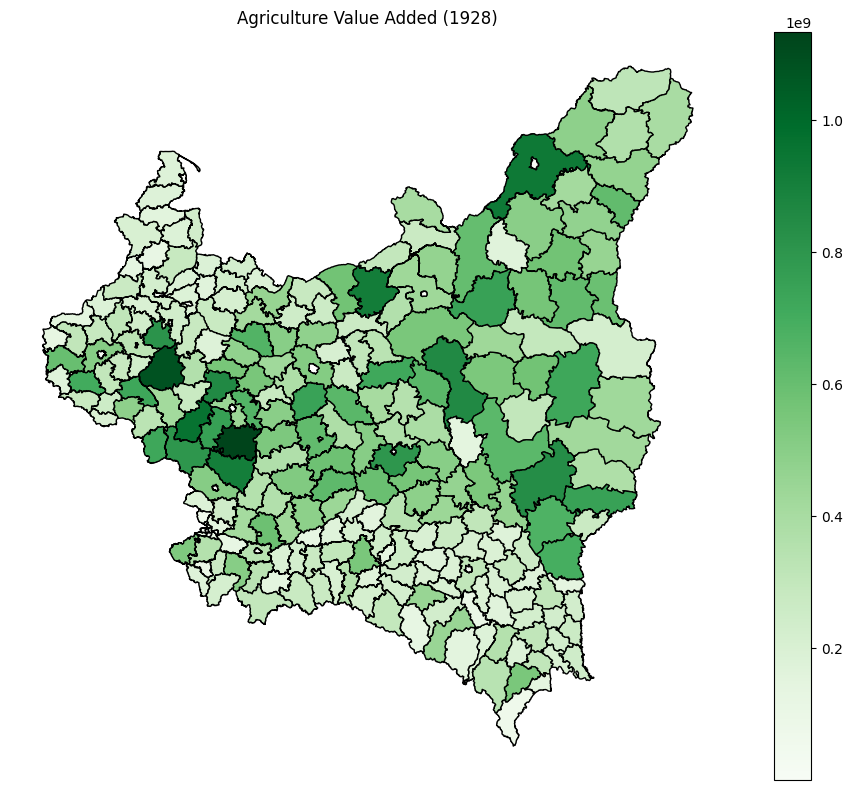

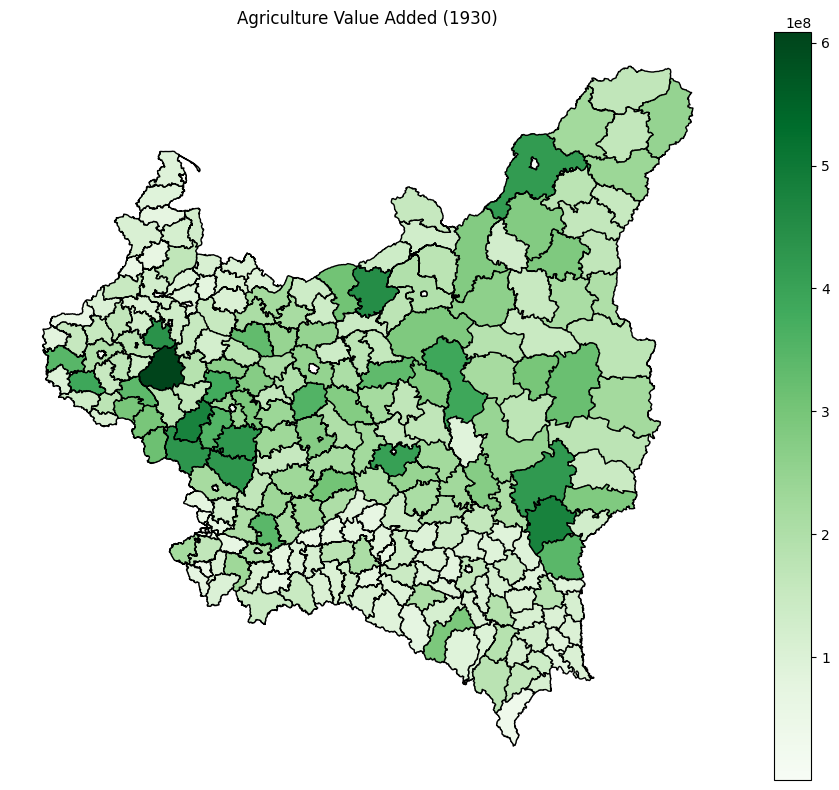

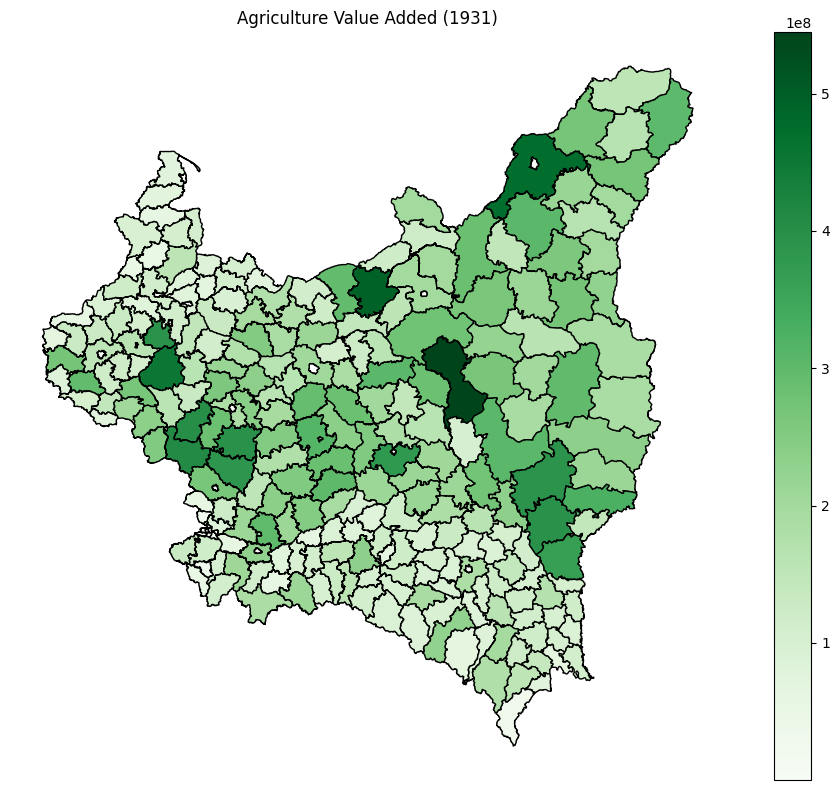

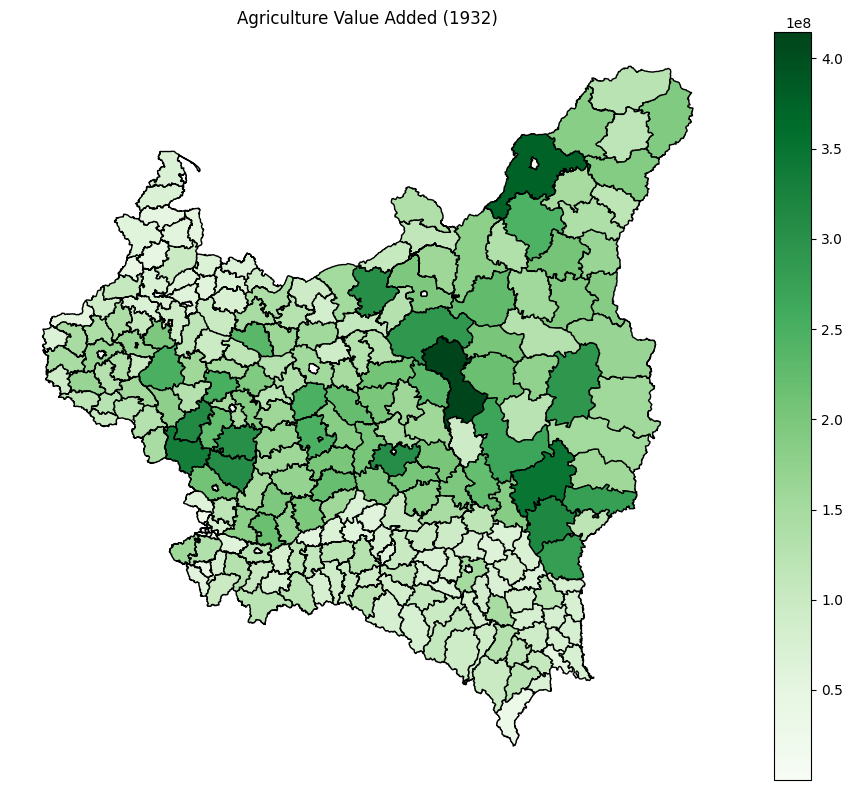

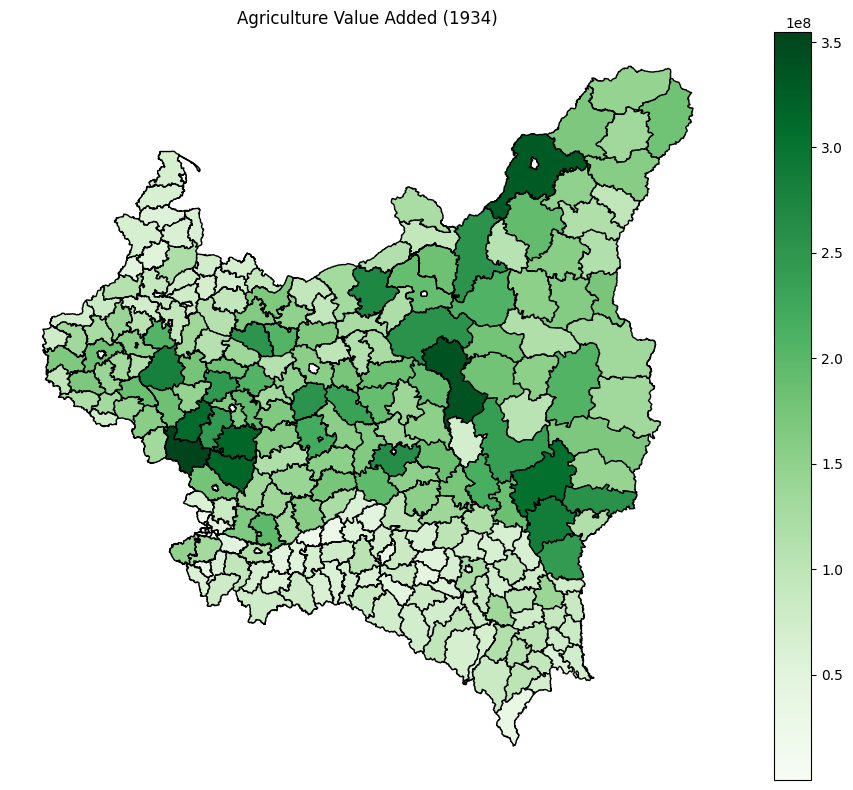

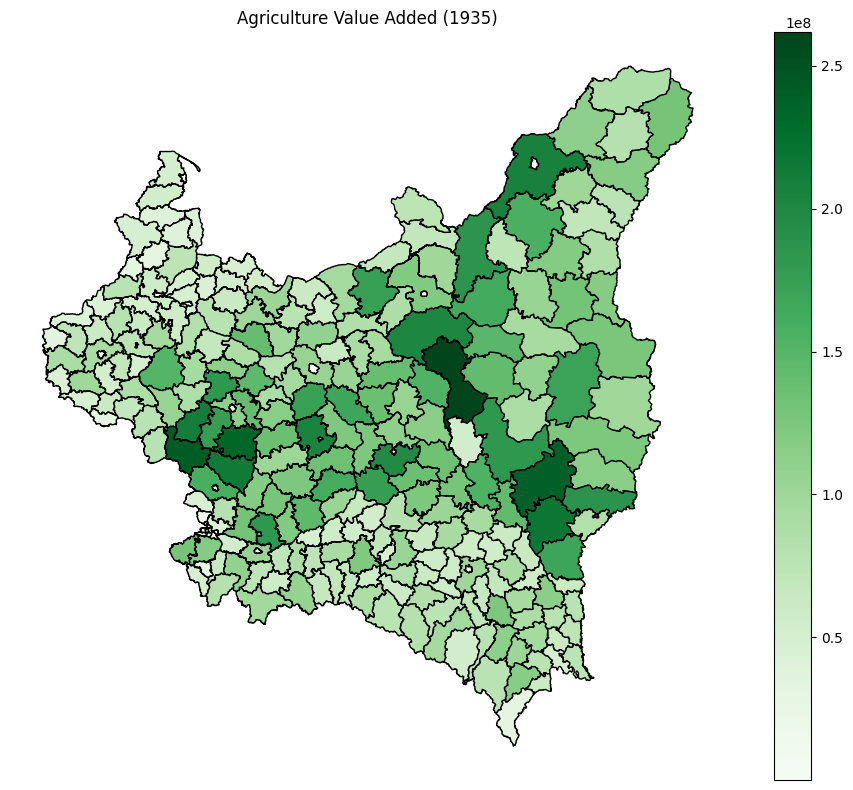

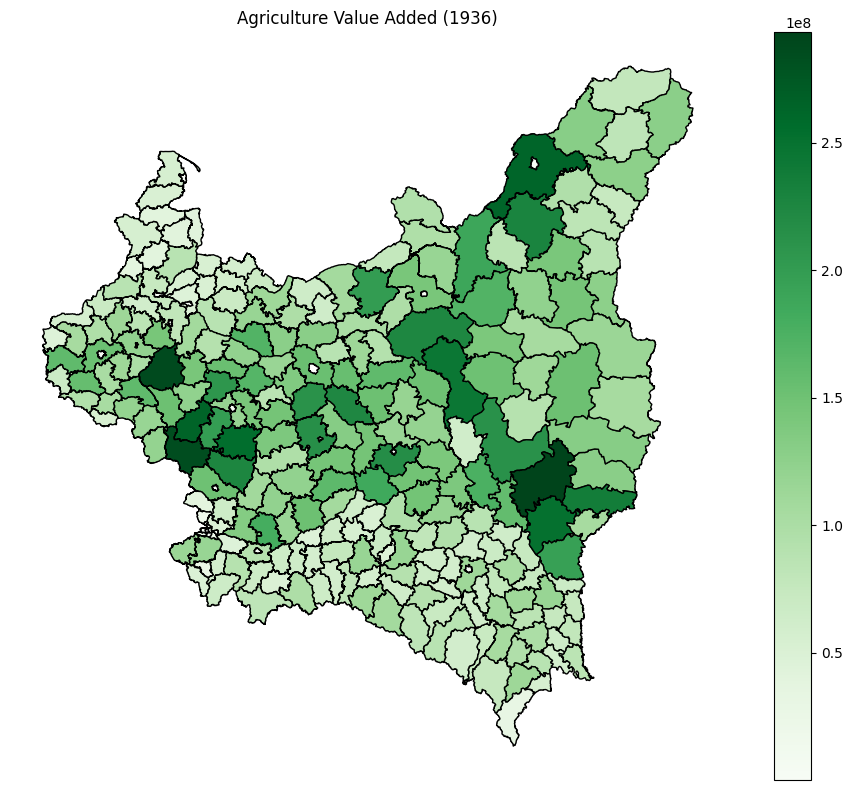

In [76]:
# Plot aggriculture production by district
for year in crops_production_years.keys():
    plot_path = plots_output_path + f"/Agriculture_VA_{year}.png"
    administrative_history.plot_dataset(df = production_by_year[year], col_name = 'Agriculture Value Added', adm_level='District', adm_state_date=reference_date, save_to_path=plot_path, title = f'Agriculture Value Added ({year})', cmap = 'Greens')

# Industry

### Load industry datasets

In [114]:
# Load industry_permissions datasets
industry_permissions_data_table_ids = [data_table.data_table_id for data_table in administrative_history.harmonized_data_metadata if data_table.category=='Industry Permissions']
industry_permissions_dfs = [administrative_history.load_data_table(data_table_id = industry_permissions_data_table_id, version = 'harmonized') for industry_permissions_data_table_id in industry_permissions_data_table_ids]
industry_permissions_year_df = {extract_date_parts(metadata.date)[0]: df for df, metadata, date in industry_permissions_dfs}
# Strip numbers from the beginning of the 1935 column names
industry_permissions_year_df[1935].columns = [re.sub(r'^\d+\.\s*', '', col) for col in industry_permissions_year_df[1935].columns]
# Strip ": Together" from column names
for year, df in industry_permissions_year_df.items():
    df.columns = df.columns.str.replace(": Together", "", regex=False)
    print(df.columns)

Index(['Kategoria IR', 'Kategoria IPR', 'Kategoria IIR', 'Kategoria IIPR',
       'Kategoria IIIR', 'Kategoria IIIPR', 'Kategoria IVR', 'Kategoria IVPR',
       'Kategoria VR', 'Kategoria VPR', 'Kategoria VIR', 'Kategoria VIPR',
       'Kategoria VIIR', 'Kategoria VIIPR', 'Kategoria VIIIR',
       'Kategoria VIIIPR'],
      dtype='object')
Index(['Kategoria IR', 'Kategoria IPR', 'Kategoria IIR', 'Kategoria IIPR',
       'Kategoria IIIR', 'Kategoria IIIPR', 'Kategoria IVR', 'Kategoria IVPR',
       'Kategoria VR', 'Kategoria VPR', 'Kategoria VIR', 'Kategoria VIPR',
       'Kategoria VIIR', 'Kategoria VIIPR', 'Kategoria VIIIR',
       'Kategoria VIIIPR'],
      dtype='object')
Index(['Kategoria IR', 'Kategoria IPR', 'Kategoria IIR', 'Kategoria IIPR',
       'Kategoria IIIR', 'Kategoria IIIPR', 'Kategoria IVR', 'Kategoria IVPR',
       'Kategoria VR', 'Kategoria VPR', 'Kategoria VIR', 'Kategoria VIPR',
       'Kategoria VIIR', 'Kategoria VIIPR', 'Kategoria VIIIR',
       'Kategoria VIIIPR

In [115]:
industry_permissions_year_df[1924].columns

Index(['Kategoria IR', 'Kategoria IPR', 'Kategoria IIR', 'Kategoria IIPR',
       'Kategoria IIIR', 'Kategoria IIIPR', 'Kategoria IVR', 'Kategoria IVPR',
       'Kategoria VR', 'Kategoria VPR', 'Kategoria VIR', 'Kategoria VIPR',
       'Kategoria VIIR', 'Kategoria VIIPR', 'Kategoria VIIIR',
       'Kategoria VIIIPR'],
      dtype='object')

## Distribution of number of workers between districts

### Compute number of workers per district for years 1924, 1925 and 1928.

In [116]:
# Industry size per category used in the estimations of Wronski et al. (2025)
industry_size_cat = {
    "I": 1250,
    "II": 750.5,
    "III": 350.5,
    "IV": 113.5,
    "V": 19,
    "VI": 8,
    "VII": 6,
    "VIII": 2.5
    }

r_pr_to_num = {"R": 1, "PR": 0.5}

In [117]:
import re

def parse_kategoria_column(col_name: str):
    match = re.match(r"Kategoria\s+([IVXLCDM]+)(P?R)", col_name.strip())
    if match:
        roman, suffix = match.groups()
        return roman, suffix
    return None

def add_total_employment_column(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    total_series = pd.Series(0.0, index=df.index)

    for col in df.columns:
        parsed = parse_kategoria_column(col)
        if parsed:
            roman, suffix = parsed
            if roman in industry_size_cat and suffix in r_pr_to_num:
                weight = industry_size_cat[roman] * r_pr_to_num[suffix]
                total_series += df[col].astype(float) * weight
            else:
                raise KeyError(f"Missing weight for category: {roman}, {suffix}")
    
    df["Total Employment"] = total_series
    return df

In [118]:
for year in [1924, 1925, 1928]:
    industry_permissions_year_df[year] = add_total_employment_column(industry_permissions_year_df[year])

## Compute total number of workers per district per industry category for year 1935

In [119]:
regional_workers_num, regional_workers_num_metadata, _ = administrative_history.load_data_table(data_table_id = "regions_1935_total_num_workers", version = 'harmonized')
regional_workers_num.columns = regional_workers_num.columns.str.replace(": Together", "", regex=False)

In [120]:
regional_workers_num.columns

Index(['Total', 'Mining and Industry - Total', 'Mining', 'Mineral',
       'Metal and electrotechnical', 'Chemical', 'Textile', 'Paper', 'Leather',
       'Wood', 'Food', 'Clothing and Toymaking', 'Printing', 'Construction',
       'Power plants and waterworks', 'Public works'],
      dtype='object')

In [121]:
regional_workers_share, regional_workers_share_metadata, _ = administrative_history.load_data_table(data_table_id = "regions_1935_share_workers_by_enterprise_type_size", version = 'harmonized')
regional_workers_share.columns

Index(['Plants: I-III', 'Mining: I-III', 'Mineral: I-III', 'Metal: I-III',
       'Electrotechnical: I-III', 'Chemical: I-III', 'Textile: I-III',
       'Paper: I-III', 'Leather: I-III', 'Wood: I-III', 'Food: I-III',
       'Clothing and Toymaking: I-III', 'Printing: I-III',
       'Construction: I-III', 'Power plants and waterworks: I-III',
       'Plants: IV-V', 'Mining: IV-V', 'Mineral: IV-V', 'Metal: IV-V',
       'Electrotechnical: IV-V', 'Chemical: IV-V', 'Textile: IV-V',
       'Paper: IV-V', 'Leather: IV-V', 'Wood: IV-V', 'Food: IV-V',
       'Clothing and Toymaking: IV-V', 'Printing: IV-V', 'Construction: IV-V',
       'Power plants and waterworks: IV-V', 'Plants: VI-VII', 'Mining: VI-VII',
       'Mineral: VI-VII', 'Metal: VI-VII', 'Electrotechnical: VI-VII',
       'Chemical: VI-VII', 'Textile: VI-VII', 'Paper: VI-VII',
       'Leather: VI-VII', 'Wood: VI-VII', 'Food: VI-VII',
       'Clothing and Toymaking: VI-VII', 'Printing: VI-VII',
       'Construction: VI-VII', 'Power 

In [122]:
def sum_industry_categories(df: pd.DataFrame) -> pd.DataFrame:
    result = pd.DataFrame(index=df.index)

    # Track handled industries
    processed_industries = set()

    for col in df.columns:
        if ": I-III" in col:
            base = col.split(":")[0].strip()
            col_iv_v = f"{base}: IV-V"
            col_i_iii = col
            cols_to_sum = [df[col_i_iii]]
            if col_iv_v in df.columns:
                cols_to_sum.append(df[col_iv_v])
            result[f"{base}: I-V"] = sum(cols_to_sum)
            processed_industries.add(col_i_iii)
            processed_industries.add(col_iv_v)
        elif ": VI-VII" in col:
            result[col] = df[col]
            processed_industries.add(col)

    # Add any columns that were not matched above (e.g. if IV-V exists but I-III doesn’t)
    for col in df.columns:
        if col not in processed_industries:
            result[col] = df[col]

    return result

# Example usage:
regional_workers_share = sum_industry_categories(regional_workers_share)

In [123]:
regional_workers_share

Plants: I-V  Mining: I-V  Mineral: I-V  Metal: I-V  \
Region                                                                
BIAŁOSTOCKIE            81.0          0.0          81.2        15.0   
KIELECKIE               92.1         98.1          89.0        97.0   
KRAKOWSKIE              81.5         78.1          84.5        86.9   
LUBELSKIE               70.6          0.0          79.8        86.5   
LWOWSKIE                62.7         25.3          67.4        74.8   
ŁÓDZKIE                 88.5          0.0          76.0        83.7   
M. ST. WARSZAWA         79.9          0.0          73.4        87.4   
NOWOGRÓDZKIE            65.4          0.0          81.8        87.7   
POLESKIE                68.4          0.0          39.2         0.0   
POMORSKIE               72.4          0.0          77.8        85.1   
POZNAŃSKIE              78.8         98.7          90.5        79.8   
STANISŁAWOWSKIE         77.4         77.0          64.4        62.3   
ŚLĄSKIE                 94.3         99.8          88.8        96.7   
TARNOPOLSKIE            51.5          0.0          32.5         0.0   
WARSZAWSKIE             88.4          0.0          92.3        96.5   
WOŁYŃSKIE               82.9          0.0          95.8        26.4   
ZIEMIA WILEŃSKA         59.0          0.0          61.7         0.0   

                 Electrotechnical: I-V  Chemical: I-V  Textile: I-V  \
Region                                                                
BIAŁOSTOCKIE                       0.0           77.2          89.1   
KIELECKIE                         93.1           94.9          98.5   
KRAKOWSKIE                        88.7           91.7          93.4   
LUBELSKIE                          0.0           82.6           0.0   
LWOWSKIE                          78.8           90.0          90.5   
ŁÓDZKIE                           78.2           95.5          92.5   
M. ST. WARSZAWA                   93.5           82.7          85.7   
NOWOGRÓDZKIE                       0.0           90.4          48.2   
POLESKIE                           0.0           83.8          39.0   
POMORSKIE                         94.8           80.2          64.4   
POZNAŃSKIE                        94.0           80.7          88.0   
STANISŁAWOWSKIE                    0.0           69.7          60.0   
ŚLĄSKIE                           92.3           97.3          95.9   
TARNOPOLSKIE                       0.0           68.9          45.8   
WARSZAWSKIE                       99.2           97.6          97.4   
WOŁYŃSKIE                          0.0           46.7           0.0   
ZIEMIA WILEŃSKA                   97.2           81.5          22.3   

                 Paper: I-V  Leather: I-V  Wood: I-V  ...  Chemical: VI-VII  \
Region                                                ...                     
BIAŁOSTOCKIE           57.6          41.3       94.3  ...              22.8   
KIELECKIE              93.2          58.0       66.4  ...               5.1   
KRAKOWSKIE             93.4          87.0       63.4  ...               8.3   
LUBELSKIE               0.0          76.6       72.0  ...              17.4   
LWOWSKIE               58.9          79.3       70.6  ...              10.0   
ŁÓDZKIE                75.9          66.8       73.5  ...               4.5   
M. ST. WARSZAWA        74.9          77.6       66.4  ...              17.3   
NOWOGRÓDZKIE           98.2           0.0       76.6  ...               9.6   
POLESKIE                0.0           0.0       84.4  ...              16.2   
POMORSKIE             100.0         100.0       58.6  ...              19.8   
POZNAŃSKIE             97.0          89.4       59.7  ...              19.3   
STANISŁAWOWSKIE         0.0          62.1       91.4  ...              30.3   
ŚLĄSKIE                95.8          97.3       70.5  ...               2.7   
TARNOPOLSKIE           51.6           0.0       75.3  ...              31.1   
WARSZAWSKIE            99.9          80.5       67.0 

In [124]:
industry_permissions_year_df[1935].columns

Index(['Number of workers in plants I-VII', 'Plants: total', 'Plants: I-III',
       'Plants: IV-V', 'Plants: VI-VII', 'Plants: VIII', 'Mining: I-V',
       'Mining: VI-VII', 'Mining: VIII', 'Mineral: I-V', 'Mineral: VI-VII',
       'Mineral: VIII', 'Mineral: brickyards (within others)',
       'Mineral: concrete plants (within others)',
       'Metal and electrotechnical: I-V', 'Metal and electrotechnical: VI-VII',
       'Metal and electrotechnical: VIII',
       'Metal and electrotechnical: metal production (within others)',
       'Metal and electrotechnical: blacksmithing (within others)',
       'Metal and electrotechnical: locksmithing, repairs (within others)',
       'Metal and electrotechnical: tinsmithing (within others)',
       'Metal and electrotechnical: watchmaking and jewelry (within others)',
       'Chemical: I-V', 'Chemical: VI-VII', 'Chemical: VIII',
       'Chemical: oil mills (within others)', 'Textile: I-V',
       'Textile: VI-VII', 'Textile: VIII', 'Paper: I-V

In [125]:
# Compute number of workers by plant size in each region
def compute_workers_by_plant_size(share_df: pd.DataFrame, num_df: pd.DataFrame) -> pd.DataFrame:
    results = pd.DataFrame(index=share_df.index)

    # Regular industry mapping (1:1 correspondence)
    industry_list = [
        'Mining', 'Mineral', 'Chemical', 'Textile', 'Paper', 'Leather',
        'Wood', 'Food', 'Clothing and Toymaking', 'Printing',
        'Construction', 'Power plants and waterworks'
    ]

    for industry in industry_list:
        if industry not in num_df.columns:
            print(f"Warning: '{industry}' not found in worker numbers. Skipping.")
            continue

        total_workers = num_df[industry]

        col_iv = f"{industry}: I-V"
        col_vivii = f"{industry}: VI-VII"

        results[f"{industry}: I-V"] = share_df.get(col_iv, 0) * total_workers
        results[f"{industry}: VI-VII"] = share_df.get(col_vivii, 0) * total_workers

    # Special case: "Metal and electrotechnical"
    industry = "Metal and electrotechnical"
    if industry in num_df.columns:
        total_workers = num_df[industry]

        # Average shares from "Metal" and "Electrotechnical"
        metal_iv = share_df.get("Metal: I-V", 0)
        elec_iv = share_df.get("Electrotechnical: I-V", 0)
        avg_iv = (metal_iv + elec_iv) / 2

        metal_vivii = share_df.get("Metal: VI-VII", 0)
        elec_vivii = share_df.get("Electrotechnical: VI-VII", 0)
        avg_vivii = (metal_vivii + elec_vivii) / 2

        results[f"{industry}: I-V"] = avg_iv * total_workers
        results[f"{industry}: VI-VII"] = avg_vivii * total_workers
    else:
        print("Warning: 'Metal and electrotechnical' not found in worker numbers.")

    return results

workers_by_industry_type_and_size = compute_workers_by_plant_size(share_df=regional_workers_share, num_df = regional_workers_num)

In [141]:
workers_by_industry_type_and_size

Mining: I-V  Mining: VI-VII  Mineral: I-V  Mineral: VI-VII  \
Region                                                                        
BIAŁOSTOCKIE             0.0             0.0      113192.8          26207.2   
KIELECKIE          2028413.7         39286.3     1033201.0         127699.0   
KRAKOWSKIE          862614.5        241885.5      669916.0         122884.0   
LUBELSKIE                0.0             0.0      156647.4          39652.6   
LWOWSKIE            148511.0        438489.0      179553.6          86846.4   
ŁÓDZKIE                  0.0             0.0      308028.0          97272.0   
M. ST. WARSZAWA          0.0             0.0       94172.2          34127.8   
NOWOGRÓDZKIE             0.0             0.0       66585.2          14814.8   
POLESKIE                 0.0             0.0        3998.4           6201.6   
POMORSKIE                0.0             0.0      129926.0          37074.0   
POZNAŃSKIE           61292.7           807.3      541009.0          56791.0   
STANISŁAWOWSKIE     175945.0         52555.0       41795.6          23104.4   
ŚLĄSKIE            4631119.2          9280.8      463358.4          58441.6   
TARNOPOLSKIE             0.0             0.0       16965.0          35235.0   
WARSZAWSKIE              0.0             0.0      636500.8          53099.2   
WOŁYŃSKIE                0.0             0.0      739671.8          32428.2   
ZIEMIA WILEŃSKA          0.0             0.0       25975.7          16124.3   

                 Chemical: I-V  Chemical: VI-VII  Textile: I-V  \
Region                                                           
BIAŁOSTOCKIE           52341.6           15458.4      394356.6   
KIELECKIE             498604.6           26795.4     1442631.0   
KRAKOWSKIE            467211.5           42288.5      465412.2   
LUBELSKIE              10490.2            2209.8           0.0   
LWOWSKIE              367920.0           40880.0       69956.5   
ŁÓDZKIE               819008.0           38592.0     9361277.5   
M. ST. WARSZAWA       474780.7           99319.3      362768.1   
NOWOGRÓDZKIE           65630.4            6969.6        3422.2   
POLESKIE               36872.0            7128.0        2301.0   
POMORSKIE              62957.0           15543.0        1996.4   
POZNAŃSKIE            254043.6           60756.4       72336.0   
STANISŁAWOWSKIE        25231.4           10968.6       31800.0   
ŚLĄSKIE               796692.4           22107.6      668327.1   
TARNOPOLSKIE            7096.7            3203.3        5999.8   
WARSZAWSKIE           321884.8            7915.2      363302.0   
WOŁYŃSKIE               2848.7            3251.3           0.0   
ZIEMIA WILEŃSKA        21271.5            4828.5        4883.7   

                 Textile: VI-VII  Paper: I-V  Paper: VI-VII  ...  \
Region                                                       ...   
BIAŁOSTOCKIE             48243.4      2304.0         1696.0  ...   
KIELECKIE                21969.0    228340.0        16660.0  ...   
KRAKOWSKIE               32887.8    158499.8        11200.2  ...   
LUBELSKIE                 1400.0         0.0            0.0  ...   
LWOWSKIE                  7343.5     29980.1        20919.9  ...   
ŁÓDZKIE                 759022.5     78556.5        24943.5  ...   
M. ST. WARSZAWA          60531.9    147403.2        49396.8  ...   
NOWOGRÓDZKIE              3677.8     16301.2          298.8  ...   
POLESKIE                  3599.0         0.0          600.0  ...   
POMORSKIE                 1103.6     12900.0            0.0  ...   
POZNAŃSKIE                9864.0    108834.0         3366.0  ...   
STANISŁAWOWSKIE          21094.0         0.0         3300.0  ...   
ŚLĄSKIE                  28572.9    215262.6         9437.4  ...   
TARNOPOLSKIE              7100.2      5727.6         5372.4  ...   
WARSZAWSKIE               9698.0    213985.8          214.2  ...   
WOŁYŃSKIE                 3800.0     12698.4          501.6  ...   
ZIEMIA WILEŃSKA          17016.3    

In [ ]:
industry_permissions_year_df[1935].columns

Index(['Number of workers in plants I-VII', 'Plants: total', 'Plants: I-III',
       'Plants: IV-V', 'Plants: VI-VII', 'Plants: VIII', 'Mining: I-V',
       'Mining: VI-VII', 'Mining: VIII', 'Mineral: I-V', 'Mineral: VI-VII',
       'Mineral: VIII', 'Mineral: brickyards (within others)',
       'Mineral: concrete plants (within others)',
       'Metal and electrotechnical: I-V', 'Metal and electrotechnical: VI-VII',
       'Metal and electrotechnical: VIII',
       'Metal and electrotechnical: metal production (within others)',
       'Metal and electrotechnical: blacksmithing (within others)',
       'Metal and electrotechnical: locksmithing, repairs (within others)',
       'Metal and electrotechnical: tinsmithing (within others)',
       'Metal and electrotechnical: watchmaking and jewelry (within others)',
       'Chemical: I-V', 'Chemical: VI-VII', 'Chemical: VIII',
       'Chemical: oil mills (within others)', 'Textile: I-V',
       'Textile: VI-VII', 'Textile: VIII', 'Paper: I-V

In [131]:
rename_map = {
    'Power plants and waterworks: I-V': 'Power plants: I-V',
    'Power plants and waterworks: VI-VII': 'Power plants: VI-VII',
    'Clothing and Toymaking: I-V': 'Clothing: I-V',
    'Clothing and Toymaking: VI-VII': 'Clothing: VI-VII'
}

workers_by_industry_type_and_size.rename(columns=rename_map, inplace=True)

In [147]:
plants_by_main_industry_type = industry_permissions_year_df[1935][['Number of workers in plants I-VII'] + list(workers_by_industry_type_and_size.columns)]
plants_by_main_industry_type

Number of workers in plants I-VII  Mining: I-V  \
District                                                                    
AUGUSTOWSKI                                            421.0          0.0   
BIAŁOSTOCKI                                           1818.0          0.0   
BIELSKI (BIELSK PODLASKI)                             2846.0          0.0   
GRODZIEŃSKI                                           2806.0          0.0   
ŁOMŻYŃSKI                                              504.0          0.0   
...                                                      ...          ...   
DZIŚNIEŃSKI                                            330.0          0.0   
WILEJSKI                                               348.0          0.0   
WILEŃSKO-TROCKI                                       1194.0          0.0   
POSTAWSKI                                              201.0          0.0   
MOŁODECZAŃSKI                                          267.0          0.0   

                           Mining: VI-VII  Mineral: I-V  Mineral: VI-VII  \
District                                                                   
AUGUSTOWSKI                           0.0           0.0              0.0   
BIAŁOSTOCKI                           0.0           1.0              6.0   
BIELSKI (BIELSK PODLASKI)             0.0           9.0              6.0   
GRODZIEŃSKI                           0.0           3.0              4.0   
ŁOMŻYŃSKI                             0.0           1.0              3.0   
...                                   ...           ...              ...   
DZIŚNIEŃSKI                           0.0           0.0              0.0   
WILEJSKI                              0.0           0.0              0.0   
WILEŃSKO-TROCKI                       0.0           2.0              8.0   
POSTAWSKI                             0.0           0.0              6.0   
MOŁODECZAŃSKI                         0.0           0.0              3.0   

                           Chemical: I-V  Chemical: VI-VII  Textile: I-V  \
District                                                                   
AUGUSTOWSKI                          0.0               1.0           0.0   
BIAŁOSTOCKI                          0.0               8.0          10.0   
BIELSKI (BIELSK PODLASKI)            2.0               9.0           0.0   
GRODZIEŃSKI                          0.0               1.0           0.0   
ŁOMŻYŃSKI                            0.0               0.0           1.0   
...                                  ...               ...           ...   
DZIŚNIEŃSKI                          0.0               2.0           0.0   
WILEJSKI                             0.0               0.0           0.0   
WILEŃSKO-TROCKI                      0.0               0.0           1.0   
POSTAWSKI                            0.0               0.0           0.0   
MOŁODECZAŃSKI                        1.0               0.0           0.0   

                           Textile: VI-VII  Paper: I-V  ...  Clothing: I-V  \
District                                                ...                  
AUGUSTOWSKI                            0.0         0.0  ...            0.0   
BIAŁOSTOCKI                           12.0         0.0  ...            0.0   
BIELSKI (BIELSK PODLASKI)              6.0         0.0  ...            0.0   
GRODZIEŃSKI                            0.0         0.0  ...            0.0   
ŁOMŻYŃSKI                              1.0         0.0  ...            0.0   
...                                    ...         ...  ...            ...   
DZIŚNIEŃSKI                            1.0         0.0  ...            0.0   
WILEJSKI                               0.0         1.0  ...            0.0   
WILEŃSKO-TROCKI                        0.0         4.0  ...            1.0   
POSTAWSKI                              0.0         0.0  ...            0.0   
MOŁODECZAŃSKI                          0.0         0.0  ...            0.0   

                           Cloth

In [152]:
def estimate_workers_by_industry(plants_by_main_industry_type, workers_by_industry_type_and_size, d_to_r):
    # Columns to distribute (exclude the total workers column)
    industry_cols = [col for col in plants_by_main_industry_type.columns if col != 'Number of workers in plants I-VII']

    # Add region column to the district dataframe
    plants_by_main_industry_type = plants_by_main_industry_type.copy()
    plants_by_main_industry_type['Region'] = plants_by_main_industry_type.index.map(d_to_r)

    # Precompute regional totals for selected columns for shares calculation
    # Sum across columns for each region in workers_by_industry_type_and_size (row-wise sum)
    regional_totals = workers_by_industry_type_and_size[industry_cols].sum(axis=1)

    # Prepare an output dataframe, same shape as workers_per_industry_type (without total column)
    estimated_df = pd.DataFrame(index=plants_by_main_industry_type.index, columns=industry_cols, dtype=float)

    for district, row in plants_by_main_industry_type.iterrows():
        region = row['Region']
        total_workers_in_district = row['Number of workers in plants I-VII']

        # Get the regional data row
        try:
            regional_data = workers_by_industry_type_and_size.loc[region, industry_cols]
        except KeyError:
            # If region not found in regional data, fill with NaN or zeros
            estimated_df.loc[district] = np.nan
            continue
        
        regional_total = regional_totals.get(region, np.nan)

        if pd.isna(regional_total) or regional_total == 0:
            # Avoid division by zero, set NaNs
            estimated_df.loc[district] = np.nan
            continue

        # Calculate regional shares per industry/size
        shares = regional_data / regional_total

        # Estimate workers per industry/size for district (proportional allocation)
        estimated = shares * total_workers_in_district

        # Scale to make sure the sum matches total_workers_in_district (due to floating point)
        scaling_factor = total_workers_in_district / estimated.sum()
        estimated *= scaling_factor

        # Assign to output dataframe
        estimated_df.loc[district] = estimated

    return estimated_df

In [153]:
workers_per_dist_estimates = estimate_workers_by_industry(plants_by_main_industry_type, workers_by_industry_type_and_size, d_to_r)
workers_per_dist_estimates

C:\Users\janek\AppData\Local\Temp\ipykernel_17524\1929833603.py:42: RuntimeWarning: invalid value encountered in scalar divide
  scaling_factor = total_workers_in_district / estimated.sum()
C:\Users\janek\AppData\Local\Temp\ipykernel_17524\1929833603.py:42: RuntimeWarning: invalid value encountered in scalar divide
  scaling_factor = total_workers_in_district / estimated.sum()
C:\Users\janek\AppData\Local\Temp\ipykernel_17524\1929833603.py:42: RuntimeWarning: invalid value encountered in scalar divide
  scaling_factor = total_workers_in_district / estimated.sum()


Mining: I-V  Mining: VI-VII  Mineral: I-V  \
District                                                               
AUGUSTOWSKI                        0.0             0.0     30.475263   
BIAŁOSTOCKI                        0.0             0.0    131.601017   
BIELSKI (BIELSK PODLASKI)          0.0             0.0    206.015674   
GRODZIEŃSKI                        0.0             0.0    203.120162   
ŁOMŻYŃSKI                          0.0             0.0     36.483450   
...                                ...             ...           ...   
DZIŚNIEŃSKI                        0.0             0.0     15.442228   
WILEJSKI                           0.0             0.0     16.284532   
WILEŃSKO-TROCKI                    0.0             0.0     55.872790   
POSTAWSKI                          0.0             0.0      9.405721   
MOŁODECZAŃSKI                      0.0             0.0     12.494167   

                           Mineral: VI-VII  Chemical: I-V  Chemical: VI-VII  \
District                                                                      
AUGUSTOWSKI                       7.055849      14.092098          4.161915   
BIAŁOSTOCKI                      30.469201      60.853763         17.972355   
BIELSKI (BIELSK PODLASKI)        47.698210      95.263921         28.134940   
GRODZIEŃSKI                      47.027821      93.925005         27.739509   
ŁOMŻYŃSKI                         8.446907      16.870350          4.982435   
...                                    ...            ...               ...   
DZIŚNIEŃSKI                       9.585694      12.645640          2.870483   
WILEJSKI                         10.108551      13.335403          3.027055   
WILEŃSKO-TROCKI                  34.682785      45.754226         10.385929   
POSTAWSKI                         5.838559       7.702345          1.748385   
MOŁODECZAŃSKI                     7.755698      10.231473          2.322482   

                           Textile: I-V  Textile: VI-VII  Paper: I-V  \
District                                                               
AUGUSTOWSKI                  106.173901        12.988726    0.620313   
BIAŁOSTOCKI                  458.489671        56.089084    2.678693   
BIELSKI (BIELSK PODLASKI)    717.745657        87.805024    4.193377   
GRODZIEŃSKI                  707.657875        86.570941    4.134440   
ŁOMŻYŃSKI                    127.106047        15.549449    0.742608   
...                                 ...              ...         ...   
DZIŚNIEŃSKI                    2.903299        10.115977   42.688600   
WILEJSKI                       3.061660        10.667758   45.017069   
WILEŃSKO-TROCKI               10.504662        36.601445  154.455117   
POSTAWSKI                      1.768373         6.161550   26.001238   
MOŁODECZAŃSKI                  2.349032         8.184745   34.538958   

                           Paper: VI-VII  ...  Clothing: I-V  \
District                                  ...                  
AUGUSTOWSKI                     0.456620  ...       0.398465   
BIAŁOSTOCKI                     1.971816  ...       1.720688   
BIELSKI (BIELSK PODLASKI)       3.086792  ...       2.693662   
GRODZIEŃSKI                     3.043407  ...       2.655804   
ŁOMŻYŃSKI                       0.546642  ...       0.477022   
...                                  ...  ...            ...   
DZIŚNIEŃSKI                     1.184576  ...       4.130499   
WILEJSKI                        1.249189  ...       4.355799   
WILEŃSKO-TROCKI                 4.286010  ...      14.944896   
POSTAWSKI                       0.721514  ...       2.515849   
MOŁODECZAŃSKI                   0.958429  ...       3.341949   

                           Clothing: VI-VII  Printing: I-V  Printing: VI-VII  \
District                                                                       
AUGUSTOWSKI                        1.755401       3.959990          1.532368   
BIAŁOSTOCKI                        7.580329      17.

In [154]:
plants_by_main_industry_type

Number of workers in plants I-VII  Mining: I-V  \
District                                                                    
AUGUSTOWSKI                                            421.0          0.0   
BIAŁOSTOCKI                                           1818.0          0.0   
BIELSKI (BIELSK PODLASKI)                             2846.0          0.0   
GRODZIEŃSKI                                           2806.0          0.0   
ŁOMŻYŃSKI                                              504.0          0.0   
...                                                      ...          ...   
DZIŚNIEŃSKI                                            330.0          0.0   
WILEJSKI                                               348.0          0.0   
WILEŃSKO-TROCKI                                       1194.0          0.0   
POSTAWSKI                                              201.0          0.0   
MOŁODECZAŃSKI                                          267.0          0.0   

                           Mining: VI-VII  Mineral: I-V  Mineral: VI-VII  \
District                                                                   
AUGUSTOWSKI                           0.0           0.0              0.0   
BIAŁOSTOCKI                           0.0           1.0              6.0   
BIELSKI (BIELSK PODLASKI)             0.0           9.0              6.0   
GRODZIEŃSKI                           0.0           3.0              4.0   
ŁOMŻYŃSKI                             0.0           1.0              3.0   
...                                   ...           ...              ...   
DZIŚNIEŃSKI                           0.0           0.0              0.0   
WILEJSKI                              0.0           0.0              0.0   
WILEŃSKO-TROCKI                       0.0           2.0              8.0   
POSTAWSKI                             0.0           0.0              6.0   
MOŁODECZAŃSKI                         0.0           0.0              3.0   

                           Chemical: I-V  Chemical: VI-VII  Textile: I-V  \
District                                                                   
AUGUSTOWSKI                          0.0               1.0           0.0   
BIAŁOSTOCKI                          0.0               8.0          10.0   
BIELSKI (BIELSK PODLASKI)            2.0               9.0           0.0   
GRODZIEŃSKI                          0.0               1.0           0.0   
ŁOMŻYŃSKI                            0.0               0.0           1.0   
...                                  ...               ...           ...   
DZIŚNIEŃSKI                          0.0               2.0           0.0   
WILEJSKI                             0.0               0.0           0.0   
WILEŃSKO-TROCKI                      0.0               0.0           1.0   
POSTAWSKI                            0.0               0.0           0.0   
MOŁODECZAŃSKI                        1.0               0.0           0.0   

                           Textile: VI-VII  Paper: I-V  ...  Clothing: I-V  \
District                                                ...                  
AUGUSTOWSKI                            0.0         0.0  ...            0.0   
BIAŁOSTOCKI                           12.0         0.0  ...            0.0   
BIELSKI (BIELSK PODLASKI)              6.0         0.0  ...            0.0   
GRODZIEŃSKI                            0.0         0.0  ...            0.0   
ŁOMŻYŃSKI                              1.0         0.0  ...            0.0   
...                                    ...         ...  ...            ...   
DZIŚNIEŃSKI                            1.0         0.0  ...            0.0   
WILEJSKI                               0.0         1.0  ...            0.0   
WILEŃSKO-TROCKI                        0.0         4.0  ...            1.0   
POSTAWSKI                              0.0         0.0  ...            0.0   
MOŁODECZAŃSKI                          0.0         0.0  ...            0.0   

                           Cloth

In [ ]:
# #Harmonize single csv file
# administrative_history.harmonize_csv_file(
#                     input_csv_path=input_csv_path,
#                     output_csv_path=output_csv_path,
#                     data_table_metadata_dict=data_table_metadata_dict,
#                     date_to=reference_date
#                 )

Harmonizing csv file 'input/harmonization_input/data/1934-crops_q_ready.csv' from 1934-10-07 to 1938-04-01.
Original borders: <AdministrativeState timespan=(1934-07-23, 1937-04-01), regions=19, districts=282>.
Target borders: <AdministrativeState timespan=(1938-04-01, 1938-10-01), regions=19, districts=282>.
Attempting to read: input/harmonization_input/data/1934-crops_q_ready.csv
Ellipsis
Successfully read CSV using encoding: cp1250
⏳ Building conversion matrix from 1934-10-07 to 1938-04-01...
Constructing conversion matrix between two administrative states:
Administrative State from: <AdministrativeState timespan=(1934-07-23, 1937-04-01), regions=19, districts=282>
Administrative State to: <AdministrativeState timespan=(1938-04-01, 1938-10-01), regions=19, districts=282>
Constructing conversion dict between adm. states valid for dates 1934-10-07 and 1938-04-01
Searching districts related by territory to the district AUGUSTOWSKI.
Adding district 'AUGUSTOWSKI' state (1921-02-19, 1939-0

DataTableMetadata(data_table_id='1934-crops_q_ready', category='Crops - Size', source='Statystyka Rolnicza 1934 (Tom IV) (Warszawa 1935)', link='https://statlibr.stat.gov.pl/exlibris/aleph/a22_1/apache_media/XR7QGU6DIR588G31LYPPK1E15QTLP3.pdf', table='11. Powierzchnia zasiewów i zbiory według powiatów. 1934.', page=18, pdf_page=27, description={'pol': 'Zbiory ziemiopłodów.', 'eng': 'Harvest of crops.'}, date='30.08.1934', orig_adm_state_date=datetime.datetime(1934, 10, 7, 0, 0), adm_state_date=datetime.datetime(1938, 4, 1, 0, 0), standardization_comments='', harmonization_method='proportional_to_territory', imputation_method=None, columns={'Jęczmień': ColumnMetadata(unit='quintal', subcategory='Jęczmień', subsubcategory='Together', data_type='float', completeness=0.9128787878787878, n_na=23, n_not_na=241, completeness_after_imputation=None, n_na_after_imputation=None, n_not_na_after_imputation=None), 'Owies': ColumnMetadata(unit='quintal', subcategory='Owies', subsubcategory='Together'